## **Task 5 - Future User Adoption**

> The goal is to define an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period, and then identify which factors predict future user adoption.

> First, I have created a dataframe and added the adopted_user column using the timestamp and visited columns in the takehome_user_engagement csv file 

> Then, I have resolved the following issues in the data given:

1.   creation_time and last_session_creation_time are not datetime objects, hence converted them to datetime objcts
2.   Filled the invited_by_user_id column's NaN values with 0

> I have added active_days column by ombing last_session and creation_time data columns. Then I have merged the features dataframe and the dataframe containing target variable (adopted_user)

> Then I have plotted the scatter matrix for the dataframe. As i couldn't get much information from the scatter matrix, I have plotted the correlation heat map for the data. From the correlation heatmap, I have selected the features which are not highly correlated, dropped the visited column and created a new dataframe for machine learning. 

> Then in order to identify the factors which predict future user adoption, i have made adopted_user as my target(y) variable and rest of the features as input variables(x) and ran randomForrestClassifier algorithm to identify which features are important.

> **Conclusion:**

>From the results of RandomForrestClassifier algorithm, we can see that the important features for predicting the future user adoption are:

*   number of 'active days'('active_days')
*   organization ID ('org_id')
*   invited by user ID ('invited_by_user_id')

> Future research can involve using other useful algorithms for Feature Selection like Recursive Feature Elimination (RFE) using Logistic Regression as an estimator, Embedded methods like Lasso etc.






In [1]:
import numpy as np
import pandas as pd
import datetime  
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(101)

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [3]:
users = pd.read_csv('/content/takehome_users.csv',encoding='ISO-8859-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [ ]:
users.info()

In [5]:
users.rename(columns={'object_id':'user_id'}, inplace=True)

In [6]:
users_eng = pd.read_csv('/content/takehome_user_engagement.csv')
users_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [7]:
users_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [8]:
users_eng.time_stamp = pd.to_datetime(users_eng.time_stamp)

In [9]:
users_eng1 = users_eng.set_index('time_stamp').groupby('user_id')['visited'].resample('D').count()

In [10]:
users_eng1=pd.DataFrame(users_eng1)
users_eng1.head()

visited
user_id time_stamp         
1       2014-04-22        1
2       2013-11-15        1
        2013-11-16        0
        2013-11-17        0
        2013-11-18        0

In [11]:
users_eng1 = users_eng1.rolling(window=7, min_periods=1).sum()

In [12]:
users_eng1.reset_index(inplace=True)

In [13]:
users_eng1.head()

,user_id,time_stamp,visited
0,1,2014-04-22,1.0
1,2,2013-11-15,2.0
2,2,2013-11-16,2.0
3,2,2013-11-17,2.0
4,2,2013-11-18,2.0


In [14]:
users_eng2 = users_eng1.groupby('user_id')[['visited']].max()

In [15]:
users_eng2.head()

,visited
user_id,
1,1.0
2,3.0
3,2.0
4,3.0
5,4.0


In [16]:
users_eng2.loc[users_eng2['visited'] >= 3, 'adopted_user'] = 1
users_eng2.loc[users_eng2['visited'] < 3, 'adopted_user'] = 0

In [17]:
users_eng2['visited'] = users_eng2['visited'].astype(int)
users_eng2['adopted_user'] = users_eng2['adopted_user'].astype(int)

In [18]:
users_eng2.reset_index(inplace=True) 

In [19]:
users_eng2.head()

,user_id,visited,adopted_user
0,1,1,0
1,2,3,1
2,3,2,0
3,4,3,1
4,5,4,1


In [20]:
df = users_eng2.merge(users, how='inner', on='user_id', sort=True)

In [21]:
df.head()

,user_id,visited,adopted_user,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,1,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,3,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2,0,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,3,1,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,4,1,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


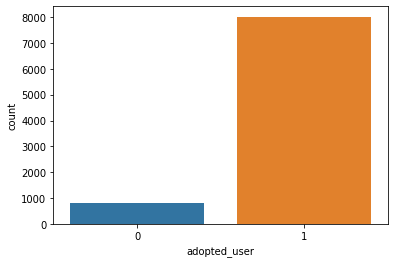

In [22]:
sns.countplot(x=df['adopted_user'])

In [23]:
df.isnull().sum()

user_id                          0
visited                          0
adopted_user                     0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            4047
dtype: int64

In [24]:
df['invited_by_user_id'].fillna(0, inplace=True)
df['invited_by_user_id'] = df['invited_by_user_id'].astype(int)

In [25]:
df.creation_time = pd.to_datetime(df.creation_time)
df.last_session_creation_time = pd.to_datetime(df.last_session_creation_time)
df['active_days'] = df['creation_time'] - df['last_session_creation_time']
df['active_days'] = df['active_days'].dt.days


In [26]:
df.head()

,user_id,visited,adopted_user,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_days
0,1,1,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803,16182
1,2,3,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316,16024
2,3,2,0,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1970-01-01 00:00:01.363734892,0,0,94,1525,15783
3,4,3,1,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.369210168,0,0,1,5151,15846
4,5,4,1,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.358849660,0,0,193,5240,15722


In [27]:
last_column = df['adopted_user']
df.drop(labels=['adopted_user'], axis=1, inplace = True)
df.insert(12, 'adopted_user', last_column)
df

,user_id,visited,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_days,adopted_user
0,1,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803,16182,0
1,2,3,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316,16024,1
2,3,2,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1970-01-01 00:00:01.363734892,0,0,94,1525,15783,0
3,4,3,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.369210168,0,0,1,5151,15846,1
4,5,4,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.358849660,0,0,193,5240,15722,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8818,11996,4,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1970-01-01 00:00:01.378448055,0,0,89,8263,15954,1
8819,11997,5,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1970-01-01 00:00:01.358274517,0,0,200,0,15715,1
8820,11998,6,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1970-01-01 00:00:01.398602716,1,1,83,8074,16187,1
8821,11999,7,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1970-01-01 00:00:01.338638159,0,0,6,0,15491,1


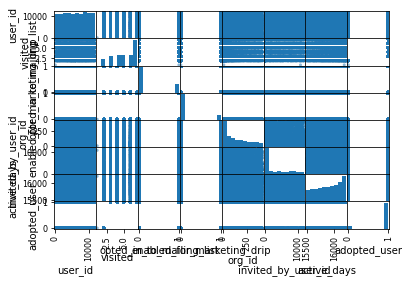

In [28]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

scatter_matrix(df)
plt.show()

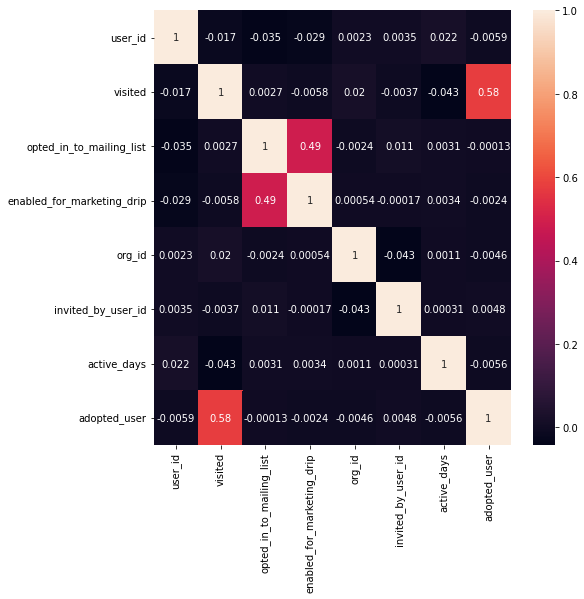

In [ ]:
import matplotlib.pyplot as plt #seaborn
sns.heatmap(df.corr(),annot=True)
fig = plt.gcf()
fig.set_size_inches(8,8)

In [ ]:
#selecting features for machine learning 

In [29]:
df1 = df[['creation_source','opted_in_to_mailing_list', 'enabled_for_marketing_drip', 
              'org_id', 'invited_by_user_id', 'active_days', 'adopted_user' ]]

In [ ]:
#creating dummies for 'creation_source' variable
creation_source_dum = pd.get_dummies(df1['creation_source'], drop_first=True)
df1.drop(['creation_source'], axis=1, inplace=True)

In [31]:
df_ml = pd.concat([df1, creation_source_dum], axis=1)

In [32]:
df_ml.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_days,adopted_user,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,0,11,10803,16182,0,0,0,0,0
1,0,0,1,316,16024,1,1,0,0,0
2,0,0,94,1525,15783,0,1,0,0,0
3,0,0,1,5151,15846,1,0,0,0,0
4,0,0,193,5240,15722,1,0,0,0,0


In [33]:
last_column = df_ml['adopted_user']
df_ml.drop(labels=['adopted_user'], axis=1, inplace = True)
df_ml.insert(9, 'adopted_user', last_column)
df_ml

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_days,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,adopted_user
0,1,0,11,10803,16182,0,0,0,0,0
1,0,0,1,316,16024,1,0,0,0,1
2,0,0,94,1525,15783,1,0,0,0,0
3,0,0,1,5151,15846,0,0,0,0,1
4,0,0,193,5240,15722,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
8818,0,0,89,8263,15954,1,0,0,0,1
8819,0,0,200,0,15715,0,0,0,1,1
8820,1,1,83,8074,16187,0,0,0,0,1
8821,0,0,6,0,15491,0,1,0,0,1


In [36]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
x=df_ml[df_ml.columns[:9]]
y=df1.adopted_user
clf.fit(x,y)
feature_imp = pd.DataFrame(clf.feature_importances_,index=x.columns)
feature_imp.sort_values(by = 0 , ascending = False)

,0
active_days,0.426145
org_id,0.334079
invited_by_user_id,0.179895
opted_in_to_mailing_list,0.019055
enabled_for_marketing_drip,0.013032
ORG_INVITE,0.010898
SIGNUP,0.006827
SIGNUP_GOOGLE_AUTH,0.005401
PERSONAL_PROJECTS,0.004669
